In [1]:
import numpy as np
import pennylane as qml 
from pennylane import numpy as np
import matplotlib.pyplot as plt
import time
from qiskit_ibm_provider import IBMProvider
from qiskit.providers.fake_provider import *
import json

In [2]:
class VQA: 

    def __init__(self, qubits, shots):
        self.qubits = qubits
        self.shots = shots

class VQSD(VQA):

    def __init__(self, qubits, shots):
        super().__init__(qubits, shots)
        #self.depth = depth

    def run(self, param = None):
        if param == None:
            param = []
            d = 1
            L = self.qubits + 2*(self.qubits - 1)*d
            for i in range(L):
                param.append(i)
        #print(param)
        
        def test_prep(param):
            for i in range(2*self.qubits):
                qml.Hadamard(i)
        
        def cost_cirq(param):
            for i in range(self.qubits):
                qml.CNOT(wires = [i,i+self.qubits])


        def rot(theta, i):
            qml.RZ(theta, wires = i)
            qml.RX(np.pi/2, wires = i)

        def initial_layer(param, q):
            for i in range(self.qubits):
                rot(param[i], i+q)

        def rot_ent(param, i, j):
            qml.CNOT(wires = [i, i+1])
            rot(param[j], i)
            rot(param[j+1], i+1)

        def rot_block(param, q):
            e = []
            o = []
            for i in range(self.qubits - 1):
                if i % 2 == 0:
                    e.append(i)
                    rot_ent(param, i + q, self.qubits + i)
                else:
                    o.append(i)
                
            for k in range(len(o)):
                rot_ent(param, o[k] + q, self.qubits + e[-1] + 2*(k+1))

        def Ansatz_block(param, q):
            initial_layer(param, q)
            rot_block(param, q)
            
        def Ansatz(param):
            Ansatz_block(param, 0)
            Ansatz_block(param, self.qubits)

        dev = qml.device("default.qubit", wires = 2*self.qubits, shots = self.shots)
        @qml.qnode(dev, interface="autograd")
        def vqsd(param):
            test_prep(param)
            Ansatz(param)
            cost_cirq(param)
            return qml.probs(wires = [i for i in range(self.qubits, 2*self.qubits)])

        drawer = qml.draw(vqsd)
        print(drawer((param)))
        #print(drawer((param)), end='\r')

        def output(param):
            return 1-vqsd(param)[0] 

        return (output(param))
#
    def eval_readout(self, param = None):
        #if param == None:
        #    param = []
        #    d = 1
        #    L = self.qubits + 2*(self.qubits - 1)*d
        #    for i in range(L):
        #        param.append(1.57)

        def opt_test_prep(param):
            for i in range(self.qubits):
                qml.Hadamard(i)
                
        def rot(theta, i):
            qml.RZ(theta, wires = i)
            qml.RX(np.pi/2, wires = i)

        def initial_layer(param, q):
            for i in range(self.qubits):
                rot(param[i], i+q)

        def rot_ent(param, i, j):
            qml.CNOT(wires = [i, i+1])
            rot(param[j], i)
            rot(param[j+1], i+1)

        def rot_block(param, q):
            e = []
            o = []
            for i in range(self.qubits - 1):
                if i % 2 == 0:
                    e.append(i)
                    rot_ent(param, i + q, self.qubits + i)
                else:
                    o.append(i)
                
            for k in range(len(o)):
                rot_ent(param, o[k] + q, self.qubits + e[-1] + 2*(k+1))

        def Ansatz_block(param, q):
            initial_layer(param, q)
            rot_block(param, q)
            
        def Ansatz(param):
            Ansatz_block(param, 0)
            Ansatz_block(param, self.qubits)

        dev2 = qml.device("default.mixed", wires = self.qubits, shots = self.shots)
        @qml.qnode(dev2, interface = "autograd")
        def eval_read(param):
            opt_test_prep(param)
            Ansatz_block(param, 0)
            return qml.probs()

        return (eval_read(param))

    def opt(self, step, theta = None):
        if theta == None:
            theta = 0
            angle = []
            t = []
            d = 1
            L = self.qubits + 2*(self.qubits - 1)*d
            for i in range(L):
                t.append(2*(np.pi)*(np.random.uniform()))
            theta = np.array(t, requires_grad=True)
            angle = [theta]

        else:
            angle = theta
        
        error = []
        diag = []
        Ev = []

        diag = [self.run(theta)]
        Ev = [self.eval_readout(theta)]

        opt = qml.GradientDescentOptimizer(stepsize=step)
        #try ADAM
        max_iterations = 1000
        conv_tol = 1e-03
        start_time = time.time()

        print("\n" f"initial value of the circuit parameter = {angle[0]}")

        for n in range(max_iterations):
            theta, prev_diag = opt.step_and_cost(self.run, theta)

            diag.append(self.run(theta))
            angle.append(theta)
            Ev = np.vstack((Ev, self.eval_readout(theta)))
            conv = 1 - max(Ev[-1,:])
            error.append(conv)         

            if n % 10 == 0:
                print(f"Step = {n},  Diagonality = {diag[-1]:.8f}, Eigen_Values = {Ev[-1]}")
            
            if n == max_iterations:
                print("\n"f"Max iterations = {max_iterations}")
                break
    
            if round(conv.item(), 3) <= conv_tol:
                max_iterations = n
                print("\n"f"Max iterations = {n}")
                print(f"The max eigenvalue is {max(Ev[-1,:])}")
                print(f"The convergence is {conv}")
                print(f"The eigenvalue error is {round(conv.item(), 3)}")
                break
        
        Time = time.time() - start_time

        print("\n" f"Optimization runtime = {Time}s")
        print("\n" f"Optimal value of the circuit parameter = {angle[-1]}")
        print("\n" f"Eigenvalues are: {Ev[-1,:]}")

        fig = plt.figure()
        fig.set_figheight(5)
        fig.set_figwidth(12)
        
        #data = {
        ##    "n_qubits": self.qubits, 
        #    "cost_history": diag, 
        ##    "error_history": error,
        #    "ansatz": f"Single Layer Simplified 2-Design",
        #    "cost": f"Global",
        #    "optimizer": '{opt}',
        #    "error_threshold": conv_tol,
        #    #"noise_model": noise,
        #    "Time to Solution": Time,
        #    "Iterations to Solution": max_iterations,
        #    "Final Error": conv,
        #    "Optimal_weights": angle[-1],
        #    "Initial_weights": angle[0]
        #    }
        
        #with open("test1.json", 'w') as outfile:
        #    json.dump(data, outfile)

        #print(data)
        #with open(f'data_toy_{self.qubits}.json', 'a') as fp:
        #    fp.write(",")
        #    json.dump(data, fp)

        #if save == True:
        #    filename='VQSD_'+'{self.qubits}'+'noise_model.json'
        #    script_path = os.path.abspath(__file__)
            #save_path = script_path.replace()
        #    completename = os.path,join(script_path, filename)

        #    with open(completename, 'wb') as file:
        #        pickle.dump(data, file) 

        plt.plot(range(len(diag)), diag, "k", ls = "solid")
        for i in range(len(Ev[n,:])):
            plt.plot(range(len(diag)), Ev[:,i], 'r', ls="dashed")
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

        #return(data)

In [3]:
z = VQSD(5, 100)
z.run()

0: ──H──RZ(0.00)──RX(1.57)─╭●──RZ(5.00)──RX(1.57)─────────────────────────╭●─────────────┤       
1: ──H──RZ(1.00)──RX(1.57)─╰X──RZ(6.00)──RX(1.57)─╭●──RZ(9.00)───RX(1.57)─│──╭●──────────┤       
2: ──H──RZ(2.00)──RX(1.57)─╭●──RZ(7.00)──RX(1.57)─╰X──RZ(10.00)──RX(1.57)─│──│──╭●───────┤       
3: ──H──RZ(3.00)──RX(1.57)─╰X──RZ(8.00)──RX(1.57)─╭●──RZ(11.00)──RX(1.57)─│──│──│──╭●────┤       
4: ──H──RZ(4.00)──RX(1.57)────────────────────────╰X──RZ(12.00)──RX(1.57)─│──│──│──│──╭●─┤       
5: ──H──RZ(0.00)──RX(1.57)─╭●──RZ(5.00)──RX(1.57)─────────────────────────╰X─│──│──│──│──┤ ╭Probs
6: ──H──RZ(1.00)──RX(1.57)─╰X──RZ(6.00)──RX(1.57)─╭●──RZ(9.00)───RX(1.57)────╰X─│──│──│──┤ ├Probs
7: ──H──RZ(2.00)──RX(1.57)─╭●──RZ(7.00)──RX(1.57)─╰X──RZ(10.00)──RX(1.57)───────╰X─│──│──┤ ├Probs
8: ──H──RZ(3.00)──RX(1.57)─╰X──RZ(8.00)──RX(1.57)─╭●──RZ(11.00)──RX(1.57)──────────╰X─│──┤ ├Probs
9: ──H──RZ(4.00)──RX(1.57)────────────────────────╰X──RZ(12.00)──RX(1.57)─────────────╰X─┤ ╰Probs


0.95

In [396]:
for x in range(10):
    print(x, end='\r')
    print()

0
1
2
3
4
5
6
7
8
9


In [408]:
param = 1.34

dev = qml.device("default.qubit", wires = 1, shots = 100)
@qml.qnode(dev, interface="autograd")
def circuit(param):
    qml.Hadamard(wires=0)
    qml.RZ(param, wires = 0)
    return qml.probs(wires = 0)

drawer = qml.draw(circuit)

for i in range(10):
    print(drawer((i)), end='\r')

In [373]:
z.run([1.405])

0: ──H──RZ(1.41)──RX(1.57)─╭●─┤       
1: ──H──RZ(1.41)──RX(1.57)─╰X─┤  Probs


0.010000000000000009

In [362]:
z = VQSD(1, 100)

In [383]:
qubits = 1
theta = 0
angle = []
t = []
d = 1
L = qubits + 2*(qubits - 1)*d
for i in range(L):
    #t.append(0)
    t.append(2*(np.pi)*(np.random.uniform()))
theta = np.array(t, requires_grad=True)
angle = [theta]
angle

[tensor([2.2434102], requires_grad=True)]

In [339]:
with open("test.json", 'w') as outfile:
    json.dump(data, outfile)

In [330]:
data = {
            #"n_qubits": self.qubits, 
            "cost_history": diag, 
            "error_history": error,
            "ansatz": f"Single Layer Simplified 2-Design",
            "cost": f"Global",
            "optimizer": '{opt}',
            "error_threshold": conv_tol,
            #"noise_model": noise,
            "Time to Solution": Time,
            "Iterations to Solution": max_iterations,
            "Final Error": conv,
            "Optimal_weights": angle[-1],
            "Initial_weights": angle[0]
            }

In [334]:
type(data)

dict

In [335]:
list(data)

['n_qubits']

0: ──H──RZ(5.23)──RX(1.57)─╭●──RZ(6.18)──RX(1.57)─╭●────┤       
1: ──H──RZ(4.95)──RX(1.57)─╰X──RZ(5.42)──RX(1.57)─│──╭●─┤       
2: ──H──RZ(5.23)──RX(1.57)─╭●──RZ(6.18)──RX(1.57)─╰X─│──┤ ╭Probs
3: ──H──RZ(4.95)──RX(1.57)─╰X──RZ(5.42)──RX(1.57)────╰X─┤ ╰Probs
initial value of the circuit parameter = [5.23450834 4.94620976 6.18176807 5.41661703]
0: ──H──RZ(5.23)──RX(1.57)─╭●──RZ(6.18)──RX(1.57)─╭●────┤       
1: ──H──RZ(4.95)──RX(1.57)─╰X──RZ(5.42)──RX(1.57)─│──╭●─┤       
2: ──H──RZ(5.23)──RX(1.57)─╭●──RZ(6.18)──RX(1.57)─╰X─│──┤ ╭Probs
0: ──H──RZ(5.26)──RX(1.57)─╭●──RZ(6.17)──RX(1.57)─╭●────┤       
1: ──H──RZ(4.96)──RX(1.57)─╰X──RZ(5.43)──RX(1.57)─│──╭●─┤       
2: ──H──RZ(5.26)──RX(1.57)─╭●──RZ(6.17)──RX(1.57)─╰X─│──┤ ╭Probs
Step = 0,  Diagonality = 0.69900000, Eigen_Values = [0.296 0.209 0.116 0.379]
0: ──H──RZ(5.26)──RX(1.57)─╭●──RZ(6.17)──RX(1.57)─╭●────┤       
1: ──H──RZ(4.96)──RX(1.57)─╰X──RZ(5.43)──RX(1.57)─│──╭●─┤       
2: ──H──RZ(5.26)──RX(1.57)─╭●──RZ(6.17)──RX(1.57)─╰X─│─

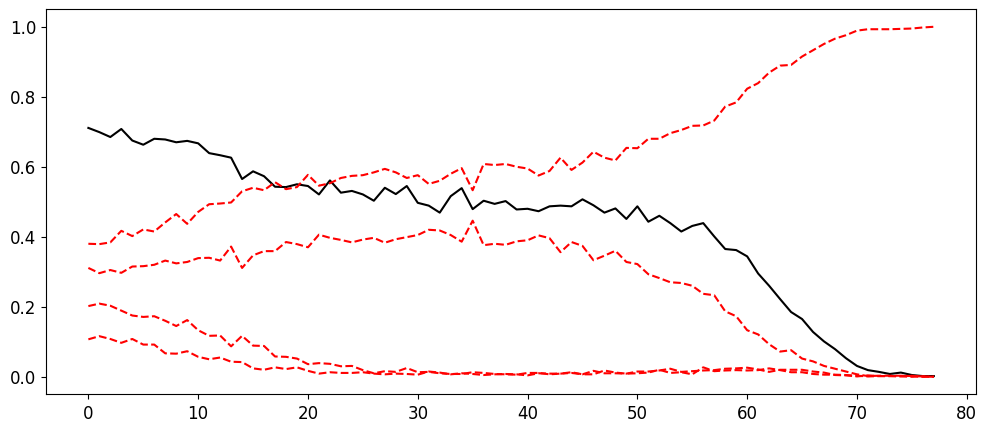

In [413]:
a = VQSD(2, 1000)
a.opt(0.2)

0: ──H──RZ(0.41)──RX(1.57)─╭●──RZ(1.47)──RX(1.57)────────────────────────╭●───────┤       
1: ──H──RZ(4.55)──RX(1.57)─╰X──RZ(6.05)──RX(1.57)─╭●──RZ(1.33)──RX(1.57)─│──╭●────┤       
2: ──H──RZ(6.24)──RX(1.57)────────────────────────╰X──RZ(4.12)──RX(1.57)─│──│──╭●─┤       
3: ──H──RZ(0.41)──RX(1.57)─╭●──RZ(1.47)──RX(1.57)────────────────────────╰X─│──│──┤ ╭Probs
4: ──H──RZ(4.55)──RX(1.57)─╰X──RZ(6.05)──RX(1.57)─╭●──RZ(1.33)──RX(1.57)────╰X─│──┤ ├Probs
5: ──H──RZ(6.24)──RX(1.57)────────────────────────╰X──RZ(4.12)──RX(1.57)───────╰X─┤ ╰Probs

initial value of the circuit parameter = [0.41462023 4.54749846 6.23650705 1.47219442 6.05201101 1.32670062
 4.11746266]
0: ──H──RZ(0.41)──RX(1.57)─╭●──RZ(1.47)──RX(1.57)────────────────────────╭●───────┤       
1: ──H──RZ(4.55)──RX(1.57)─╰X──RZ(6.05)──RX(1.57)─╭●──RZ(1.33)──RX(1.57)─│──╭●────┤       
2: ──H──RZ(6.24)──RX(1.57)────────────────────────╰X──RZ(4.12)──RX(1.57)─│──│──╭●─┤       
3: ──H──RZ(0.41)──RX(1.57)─╭●──RZ(1.47)──RX(1.57)──────────

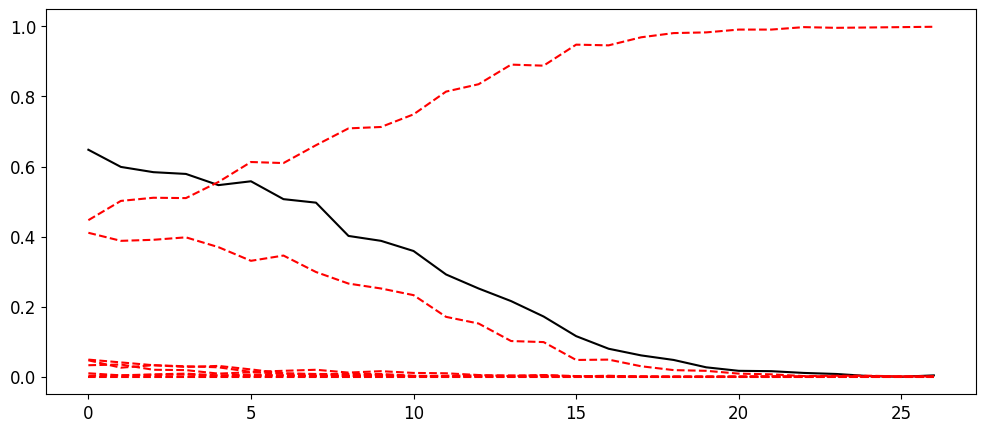

In [391]:
d = VQSD(3, 1000)
d.opt(0.2)

Step = 0,  Diagonality = 0.91000000, Eigen_Values = [0.04 0.01 0.06 0.13 0.   0.08 0.15 0.02 0.02 0.01 0.09 0.09 0.02 0.16
 0.07 0.05]
Step = 10,  Diagonality = 0.90000000, Eigen_Values = [0.03 0.02 0.1  0.07 0.   0.06 0.21 0.01 0.04 0.01 0.1  0.08 0.01 0.08
 0.14 0.04]
Step = 20,  Diagonality = 0.85000000, Eigen_Values = [0.01 0.02 0.22 0.01 0.   0.05 0.3  0.   0.   0.05 0.2  0.03 0.   0.
 0.11 0.  ]
Step = 30,  Diagonality = 0.10000000, Eigen_Values = [0.01 0.   0.05 0.   0.01 0.   0.92 0.   0.   0.   0.   0.   0.   0.
 0.01 0.  ]

Max iterations = 34

Optimization runtime = 8.151389360427856s

Optimal value of the circuit parameter = [ 2.40000000e-02 -5.53638252e-03 -1.80000000e-02  6.26942842e+00
  1.56600000e+00  3.11738990e+00 -2.70000000e-02  1.53713945e+00
  1.54800000e+00  4.65650909e+00  0.00000000e+00  1.12198263e+00
  0.00000000e+00  3.58238501e+00  0.00000000e+00  5.00475460e+00
  0.00000000e+00  1.59345277e+00  0.00000000e+00  2.02110325e+00]

Eigenvalues are: [0. 0. 0. 0

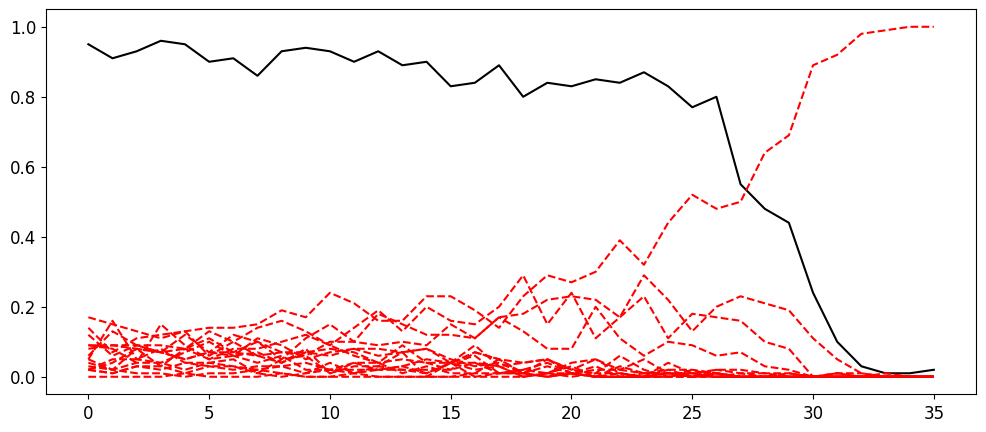

In [178]:
z = VQSD(4, 100)
z.opt(0.6)

Step = 0,  Diagonality = 0.91000000, Eigen_Values = [0.   0.02 0.   0.02 0.   0.   0.02 0.01 0.01 0.03 0.   0.   0.   0.
 0.   0.02 0.15 0.1  0.02 0.01 0.16 0.14 0.   0.01 0.   0.01 0.04 0.06
 0.01 0.02 0.05 0.09]
Step = 10,  Diagonality = 0.76000000, Eigen_Values = [0.   0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.03 0.
 0.   0.   0.19 0.27 0.   0.   0.21 0.19 0.   0.   0.   0.01 0.01 0.02
 0.   0.01 0.02 0.02]
Step = 20,  Diagonality = 0.08000000, Eigen_Values = [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.01 0.98 0.   0.   0.   0.01 0.   0.
 0.   0.   0.   0.  ]

Max iterations = 22

Optimization runtime = 8.927066087722778s

Optimal value of the circuit parameter = [-7.80000000e-02  3.21790494e+00  4.80000000e-02  8.74136258e-02
 -5.03069808e-17  1.55808933e+00 -6.00000000e-03  3.13599924e+00
 -3.30000000e-02  1.59366360e+00  1.51800000e+00  1.57752810e+00
 -1.53300000e+00  2.59169877e-01  0.00000000e+00  9.08816

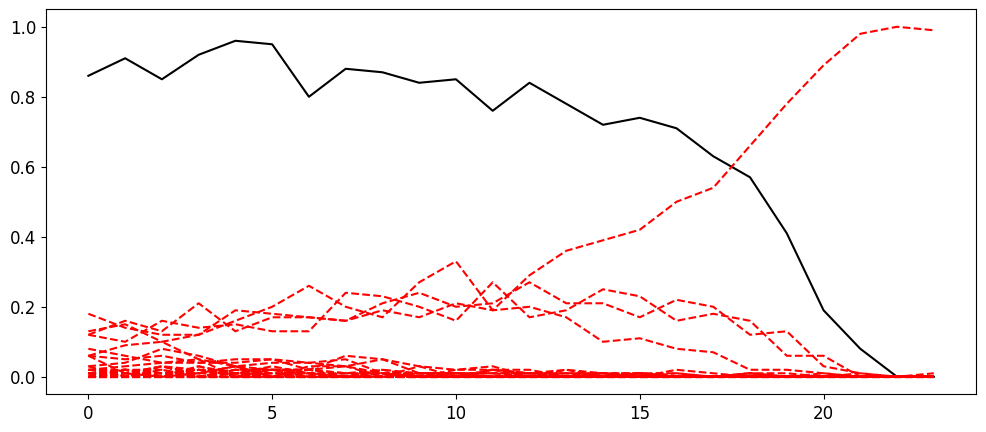

In [179]:
a = VQSD(5,100)
a.opt(0.6)

In [414]:
b = VQSD(6,100)
b.opt(0.8)

 0: ──H──RZ(2.01)──RX(1.57)─╭●──RZ(4.84)──RX(1.57)────────────────────────╭●────────────────┤       
 1: ──H──RZ(6.00)──RX(1.57)─╰X──RZ(4.48)──RX(1.57)─╭●──RZ(3.29)──RX(1.57)─│──╭●─────────────┤       
 2: ──H──RZ(2.66)──RX(1.57)─╭●──RZ(1.88)──RX(1.57)─╰X──RZ(0.24)──RX(1.57)─│──│──╭●──────────┤       
 3: ──H──RZ(1.10)──RX(1.57)─╰X──RZ(1.80)──RX(1.57)─╭●──RZ(3.27)──RX(1.57)─│──│──│──╭●───────┤       
 4: ──H──RZ(4.27)──RX(1.57)─╭●──RZ(5.32)──RX(1.57)─╰X──RZ(2.17)──RX(1.57)─│──│──│──│──╭●────┤       
 5: ──H──RZ(2.42)──RX(1.57)─╰X──RZ(5.57)──RX(1.57)────────────────────────│──│──│──│──│──╭●─┤       
 6: ──H──RZ(2.01)──RX(1.57)─╭●──RZ(4.84)──RX(1.57)────────────────────────╰X─│──│──│──│──│──┤ ╭Probs
 7: ──H──RZ(6.00)──RX(1.57)─╰X──RZ(4.48)──RX(1.57)─╭●──RZ(3.29)──RX(1.57)────╰X─│──│──│──│──┤ ├Probs
 8: ──H──RZ(2.66)──RX(1.57)─╭●──RZ(1.88)──RX(1.57)─╰X──RZ(0.24)──RX(1.57)───────╰X─│──│──│──┤ ├Probs
 9: ──H──RZ(1.10)──RX(1.57)─╰X──RZ(1.80)──RX(1.57)─╭●──RZ(3.27)──RX(1.57)──────────╰X─│──│─

KeyboardInterrupt: 

[0.         0.63080602 0.         1.83698582 0.         2.2398645
 0.         6.01457662 0.         5.38206563 0.         0.24112944
 0.         6.15630191 0.         2.03245712 0.         1.7087809
 0.         2.54717756 0.         1.89530904 0.         4.90498207
 0.         0.01776004 0.         2.01292138 0.         5.0569073
 0.         0.48357064 0.         1.05527199 0.         4.46749155
 0.         3.30930182]
Step = 0,  Diagonality = 0.98000000, Eigen_Values = [0.   0.   0.   0.02 0.   0.01 0.   0.   0.   0.   0.   0.01 0.   0.
 0.   0.03 0.   0.   0.01 0.02 0.   0.   0.05 0.02 0.02 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.01 0.03 0.   0.   0.01 0.   0.01 0.
 0.01 0.02 0.   0.01 0.01 0.01 0.   0.   0.   0.01 0.01 0.01 0.02 0.01
 0.01 0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.01 0.02 0.   0.01
 0.02 0.01 0.   0.   0.02 0.03 0.   0.   0.   0.03 0.01 0.   0.01 0.03
 0.   0.   0.03 0.01 0.   0.   0.   0.01 0.   0.   0.01 0.01 0.   0.
 0.05 0.04 0.   0.   0.06 0.04 0.   

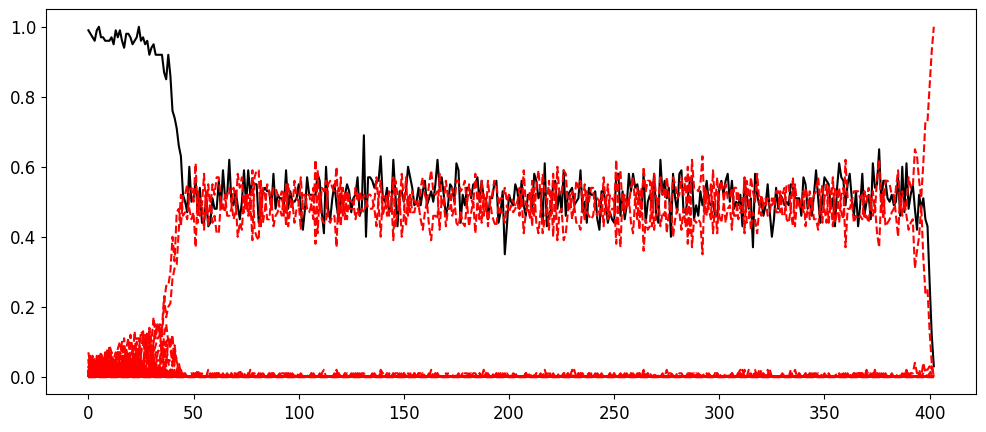

In [302]:
b = VQSD(7,100)
b.opt(1.0)

Step = 0,  Diagonality = 0.97000000, Eigen_Values = [0.   0.   0.   0.   0.01 0.   0.   0.   0.02 0.01 0.04 0.01 0.   0.
 0.01 0.   0.02 0.   0.   0.   0.   0.   0.   0.   0.05 0.03 0.01 0.
 0.   0.01 0.03 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.01 0.
 0.   0.   0.05 0.   0.   0.01 0.02 0.02 0.01 0.   0.01 0.   0.   0.01
 0.   0.   0.01 0.   0.02 0.   0.   0.   0.03 0.   0.01 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.
 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.
 0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.02 0.   0.01 0.
 0.02 0.01 0.02 0.   0.01 0.   0.   0.   0.   0.   0.01 0.   0.02 0.02
 0.02 0.   0.03 0.02 0.01 0.   0.01 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0

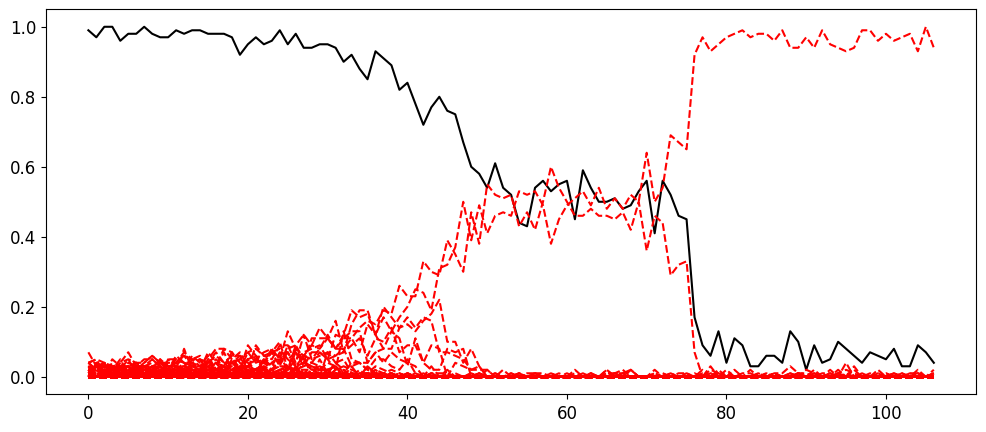

In [92]:
b = VQSD(8,100)
b.opt(1.5)

In [93]:
b = VQSD(9,100)
b.opt(1.7)

Step = 0,  Diagonality = 0.99000000, Eigen_Values = [0.01 0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.
 0.01 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.
 0.   0.   0.01 0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.01 0.   0.01 0.01 0.   0.   0.   0.01 0.
 0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.01 0.01 0.   0.
 0.   0.01 0.   0.02 0.   0.   0.   0.02 0.01 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.01 0.01 0.   0.   0.   0.02 0.   0.   0.   0.
 0.   0.   0.   0.02 0.   0.   0.   0.   0.02 0.   0.02 0.01 0.   0.
 0.   0.   0.01 0.01 0.   0.   0.   0.01 0.   0.   0.01 0.   0.   0.
 0.   0.01 0.   0.01 0.01 0.02 0.   0.   0.01 0.01 0.03 0.   0.   0.01
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.01 0.   0.
 0.   0.   0.01 0.   0.01 0.01 0.01 0.   0.   0.0

KeyboardInterrupt: 